# Predicting Borrower Behavior to Maximize Lifetime Value


###### *Why do some lendees take new loans and trade their existing cars, while others don't?*
------


>**Overview**: The data come from Chicago Acceptance's transaction history. C.A. generates revenue from financing sub-prime vehicle loans in payments over the course of 3-5 years. When customers pay off the vehicle, they are considered the full legal owner. Of course, this means the business stops generating income from borrowers who reliably made payments. The business would ideally entice these customers to purchase another vehicle, thereby taking a new loan.
>
>While previous customers are easier to interact with due to the existing relationship, it's challenging to entice someone to take on a new loan. To target C.A.'s outreach efforts, my analysis will focus on customers who traded their vehicle and financed a new one to help determine the key factors that influenced their decision. In turn, we will predict current customers who are likely to trade.

>**The Data**: 
>From a list of 400 possible variables, I hand-selected about 2-dozen which I have observed to be likely predictive of a customer trading their vehicle. After further analysis, I dropped down to only 7 variables, including 3 feature engineered variables. This process was an effort to reduce potential target leakage. 
>
>It's important to note that for those individuals who traded previously, their trade vehicle information is included in the following variables.
>
>*Trade Year, Trade Make, Trade Odometer, Trade Amount, Trade Lien, Trade Lien Held By*
>
>As mentioned, there is quite a bit of missing, incorrect, or mis-formatted data which is the reason for some alterations early in this notebook.
>
>The training dataset is comprised of ~ 1,300 open loans out of ~ 4,200 vehicle transactions between 05/01/2018 and 04/30/2022. The test data is comprised of the ~ 750 open loans from 900 transactions between 05/01/2022 to 05/01/2023.  

>**Procedure**: 
>After preprocessing the data thoroughly, I split the training data, then I constructed a decision tree to determine which variables best predicted the "trade" outcome. 
>
>Using these variables, I constructed a Random Forest, used XGBoost, and did logistic regression. Then, I evaluated each model on the unseen data from the training dataset, using F1 score and the area under the curve of the receiver operating characteristic curve.
>
>Finally, since the scores for each model were quite high, I used these models to make predictions on the recent (test) dataset and combined the data into a neat report for my boss, showing which customers were predicted to have high propensity to trade, along with which models came up with that conclusion.

------

# 1. Import the relevant libraries and data


In [274]:
import pandas as pd
import numpy as np
import sklearn

from sklearn import tree
import matplotlib.pyplot as plt
from IPython.display import Image

#models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

from sklearn.linear_model import (LogisticRegression,
                                  Ridge)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)

#metrics
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             make_scorer,
                             r2_score,
                             roc_curve, 
                             auc,
                             precision_recall_curve)

#Classes
from Preprocessing import Preprocessing
from Viz import Visualization
from Train_Metrics import Train_Metrics
from Encode_Normalize_Multicol import Encode_Normalize_Multicol


In [275]:
#import train dataset
PATH= '4Previous.csv'
df = pd.read_csv(PATH)

In [276]:
#import train dataset
PATH= 'LastYear.csv'
df2 = pd.read_csv(PATH)

In [277]:
df2 = df2.merge(df, how='left', indicator=True)
df2 = df2.loc[df2['_merge'] == 'left_only']
df2.drop('_merge', axis=1, inplace = True)

# 2. Exploratory Data Analysis

In [278]:
#Select only open deals
df = df[(df['Status Code'] == 'Open')]
df2 = df2[(df2['Status Code'] == 'Open')]

df.drop('Status Code', axis = 1, inplace = True)
df2.drop('Status Code', axis = 1, inplace = True)

In [279]:
together = pd.concat([df,df2])
df = together.sample(n = 500, random_state = 42)
df2 = together.drop(df.index)

In [280]:
#see the data 
df.head().T

,1887,305,3670,238,2499
StockNbr,201711,200644,200692,202788,190400
Balance Remaining,"17,608.85","10,323.99","13,573.96","30,577.99","7,696.13"
Total Repairs,"1,024.68",528.96,"1,226.38","1,897.86",814.43
Nbr Pmts Remaining,73,45,53,101,32
Interest Rate,14.9,19.9,24.9,18.9,19.9
Trade Year,2005.0,NaN,NaN,2012.0,NaN
Trade Make,Nissan,NaN,NaN,GMC,NaN
Trade Odometer,NaN,NaN,NaN,146226,NaN
Trade Amount,"2,000.00",0.00,0.00,"4,000.00",0.00
Trade Lien,0.00,0.00,0.00,"2,566.90",0.00


In [281]:
#Lots of object variables that should be numeric
pd.DataFrame({
    'Data Type': df.dtypes,
    'Null Percentage': round(100*df.isna().sum()/len(df),2)
})

,Data Type,Null Percentage
StockNbr,object,0.0
Balance Remaining,object,0.0
Total Repairs,object,0.0
Nbr Pmts Remaining,int64,0.0
Interest Rate,float64,0.0
Trade Year,float64,61.4
Trade Make,object,61.4
Trade Odometer,object,63.6
Trade Amount,object,0.0
Trade Lien,object,0.0


In [282]:
# Quick check for duplicates
len(df[df.duplicated()])

0

# 3. Data Preprocessing
Changing the types to numeric where needed, imputing missing data, dropping irrelevant data, setting target variables, and truncating outliers

In [283]:
#instantiate
preprocessor = Preprocessing(df)
#preprocess and set targets
preprocessor = preprocessor.process()
#reset trades (1) or don't (0)
keep_trades = int(input("Would you like to reset the trades? \n\n1=True: \n\n0=False\n\n"))
preprocessor = preprocessor.tr(keep_trades)
#drop stock numbers
train_df = preprocessor.drop('stock', axis=1)

C:\Users\ADMIN\Preprocessing.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, features + cols_with_missing] = imputer.fit_transform(train_data.loc[:, features + cols_with_missing])


variables fixed

-----

1.0% of the values (5 values) were wholesale and cash deals (deleted).

-----

outliers truncated

--------



Would you like to reset the trades? 

1=True: 

0=False

1

-----

trade vars replaced and dropped


In [284]:
print(f'{round(100*len(train_df[train_df.t1==1])/len(train_df),1)}% of our values are targets')

20.0% of our values are targets


            Target propensity per class  Total members in each class
suzuki                         1.000000                            1
pontiac                        1.000000                            1
mercury                        1.000000                            2
acura                          0.800000                            5
scion                          0.500000                            4
lexus                          0.400000                            5
mazda                          0.400000                            5
buick                          0.333333                           12
honda                          0.266667                           15
gmc                            0.263158                           19
dodge                          0.258065                           31
chevrolet                      0.250000                           92
cadillac                       0.250000                            4
lincoln                        0.2

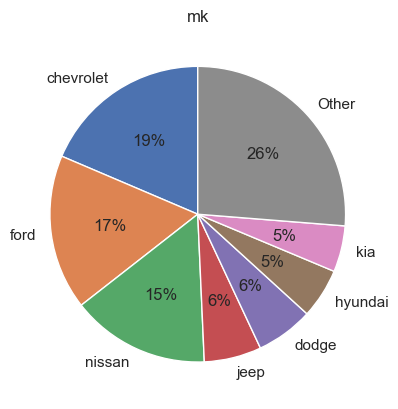

---------------------------------------------


       Target propensity per class  Total members in each class
empty                     0.253731                          134
F                         0.213836                          159
M                         0.153465                          202


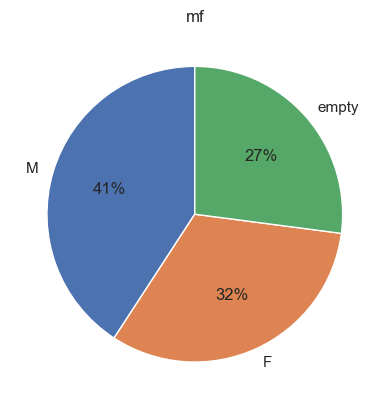

---------------------------------------------




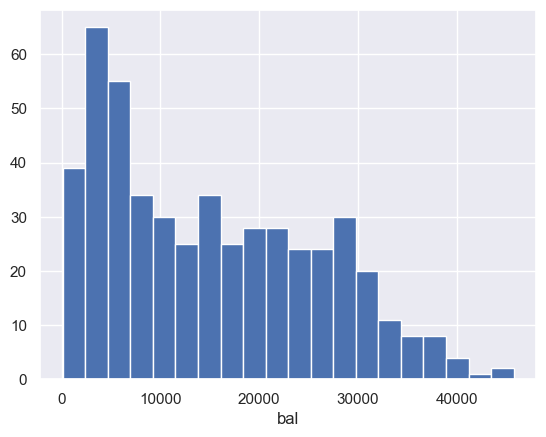

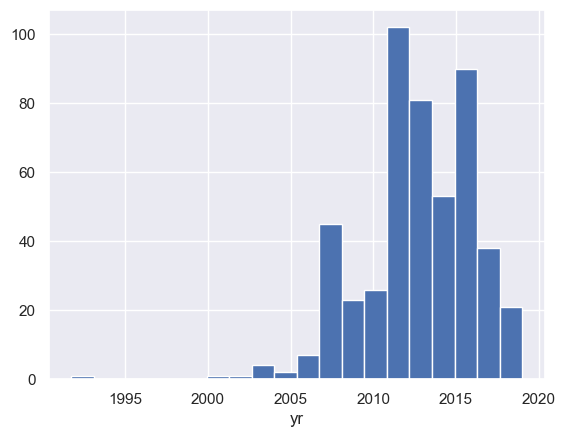

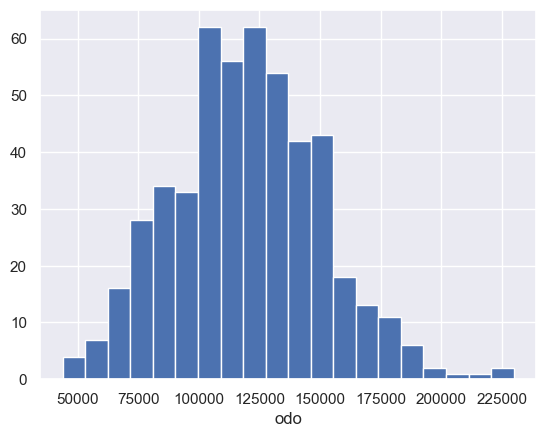

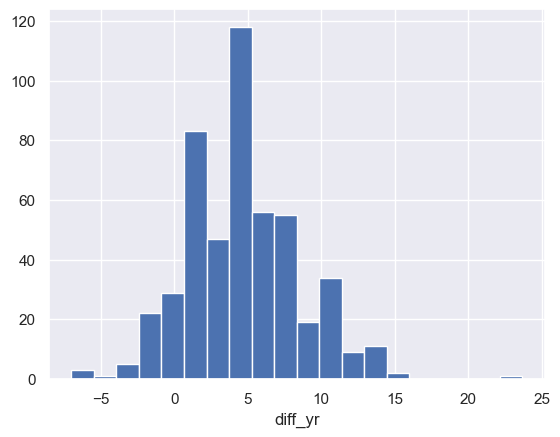

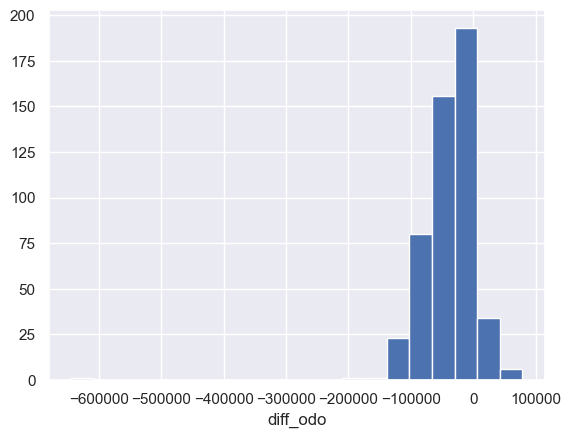

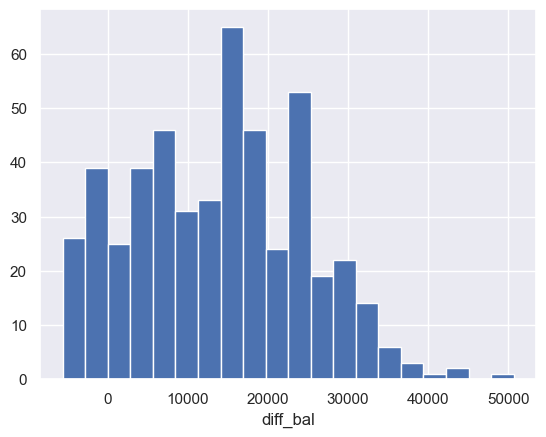

In [285]:
Visualization(train_df).all_viz()

# 4. One-Hot Encoding Categorical Variables & Removing Multicollinearity

In [286]:
#I have turned off normalization and multicollinearity reduction in the function
en_norm_mult = Encode_Normalize_Multicol(train_df, 0.8).encode_normalize_multicol()

encoded


In [287]:
corr = en_norm_mult.corr().abs()
corr_sorted_t1 = corr[['t1']].sort_values(by = 't1', ascending = False)
#Test Correlations - how is the target variable related to the top 12 predictors?
i = 12
corrdf = pd.DataFrame(corr_sorted_t1)
corrdf.drop('t1', inplace = True)
corrdf.head(i+1).T

,bal,yr,odo,mk_acura,diff_bal,mk_mercury,mk_nissan,mf_M,mk_suzuki,mk_pontiac,mf_empty,mk_chevrolet,mk_kia
t1,0.48423,0.4554,0.436729,0.149433,0.128582,0.125581,0.111514,0.104922,0.088713,0.088713,0.084775,0.068513,0.067388


# 5. Split Training Data: make sure 20% of the data remains unseen

In [288]:
zeros = en_norm_mult[en_norm_mult.t1 == 0]
ones = en_norm_mult[en_norm_mult.t1 == 1]

oversampled = pd.concat([zeros.iloc[0:len(ones),:], ones])

In [289]:
#Define X and y
variables, target = en_norm_mult.drop('t1', axis = 1), en_norm_mult.t1
# variables, target = en_norm_mult.drop(['t1', 'bal', 'diff_bal'], axis = 1), en_norm_mult.t1


#Split the data
X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.2, random_state=42)

In [224]:
# #These are the variables the decision tree ended up choosing
# vars_selected =  ['bal', 'yr', 'odo', 'diff_yr', 'diff_odo', 'diff_bal']
# X_train, X_test = X_train[vars_selected], X_test[vars_selected]

# 6. Decision Tree Classifier

In [225]:
dt_params = {
    'max_depth': list(range(1,4)),
#     'max_features': list(range(1:8))
    'min_samples_leaf': list(range(1,10)),
    'min_samples_split': list(range(1,20))
}

In [226]:
def grid_search_train_metrics(model_class, param_grid, cv, scoring, X_train, y_train, X_test, random_state=42):
    grid_search = GridSearchCV(model_class(random_state=random_state), param_grid=param_grid, cv=cv,
                               scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best hyperparameters for GridSearchCV: ', grid_search.best_params_, 'Score:', round(grid_search.best_score_, 2))

    # Handle 'random_state' argument correctly
    best_params = grid_search.best_params_
    if 'random_state' in best_params:
        del best_params['random_state']

    # because new makes are in this data, there are extra dummy variables. We need to remove the rows and columns containing these data
    extra_vars_1 = [i for i in X_train.columns if i not in X_test.columns and i != 'stock']
    extra_vars_2 = [i for i in X_test.columns if i not in X_train.columns and i != 'stock']

    # Drop extra_vars columns
    X_train = X_train.drop(columns=extra_vars_1)
    X_test = X_test.drop(columns=extra_vars_2)

    clf = model_class(random_state=random_state, **grid_search.best_params_)
    clf.fit(X_train, y_train)

    return clf, X_train, X_test

# You would then call the function with the required arguments
# For example:
# model, X_train, X_test = grid_search_train_metrics(DecisionTreeClassifier, param_grid, 5, 'accuracy', X_train, y_train, X_test)

In [227]:
model, X_train, X_test = grid_search_train_metrics(DecisionTreeClassifier, dt_params, 5, 'f1', X_train, y_train, X_test)

Best hyperparameters for GridSearchCV:  {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 1} Score: 0.73


In [228]:
#Export graphviz tree
feature_cols = list(X_train.columns.values)
tree.export_graphviz(model, out_file = 'tree_file.txt', \
                     feature_names = feature_cols, class_names = ['0','1'], filled = True, rounded = True, impurity = False)
print('-----------------------------\nExported GraphViz file \'tree_file.txt\'')

-----------------------------
Exported GraphViz file 'tree_file.txt'


In [229]:
#this function is mine - can be found in Train_Metrics.py
dt = Train_Metrics(model_class = DecisionTreeClassifier, param_grid=dt_params, cv=10, scoring='f1', \
                                 X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, \
                                 random_state = 5)

Best hyperparameters for GridSearchCV:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 1} Score: 0.78


 DecisionTreeClassifier Train accuracy: 0.937
-----------------
 DecisionTreeClassifier Train F1-score: 0.822
-----------------
 DecisionTreeClassifier Test accuracy: 0.893
-----------------
 DecisionTreeClassifier Test F1-score: 0.718 
-----------------


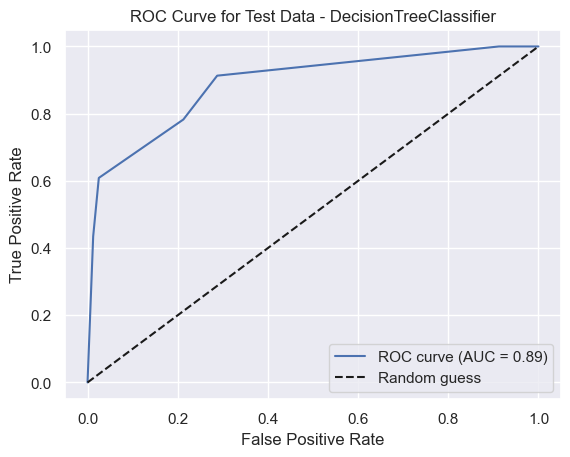

-----------------------------
Exported GraphViz file 'tree_file.txt'


Decision Tree Selected These Variables:
 ['yr', 'odo', 'diff_yr', 'diff_odo']


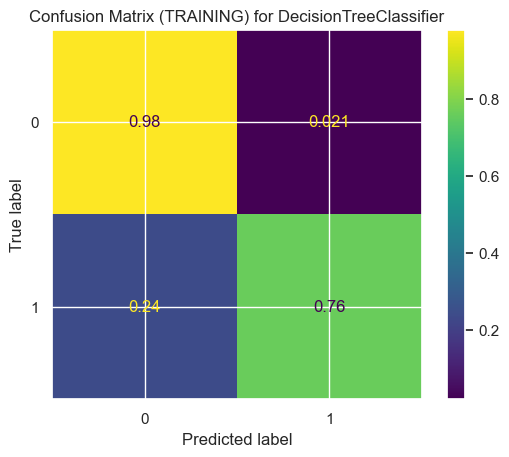

In [230]:
dt = dt.grid_search_train_metrics()

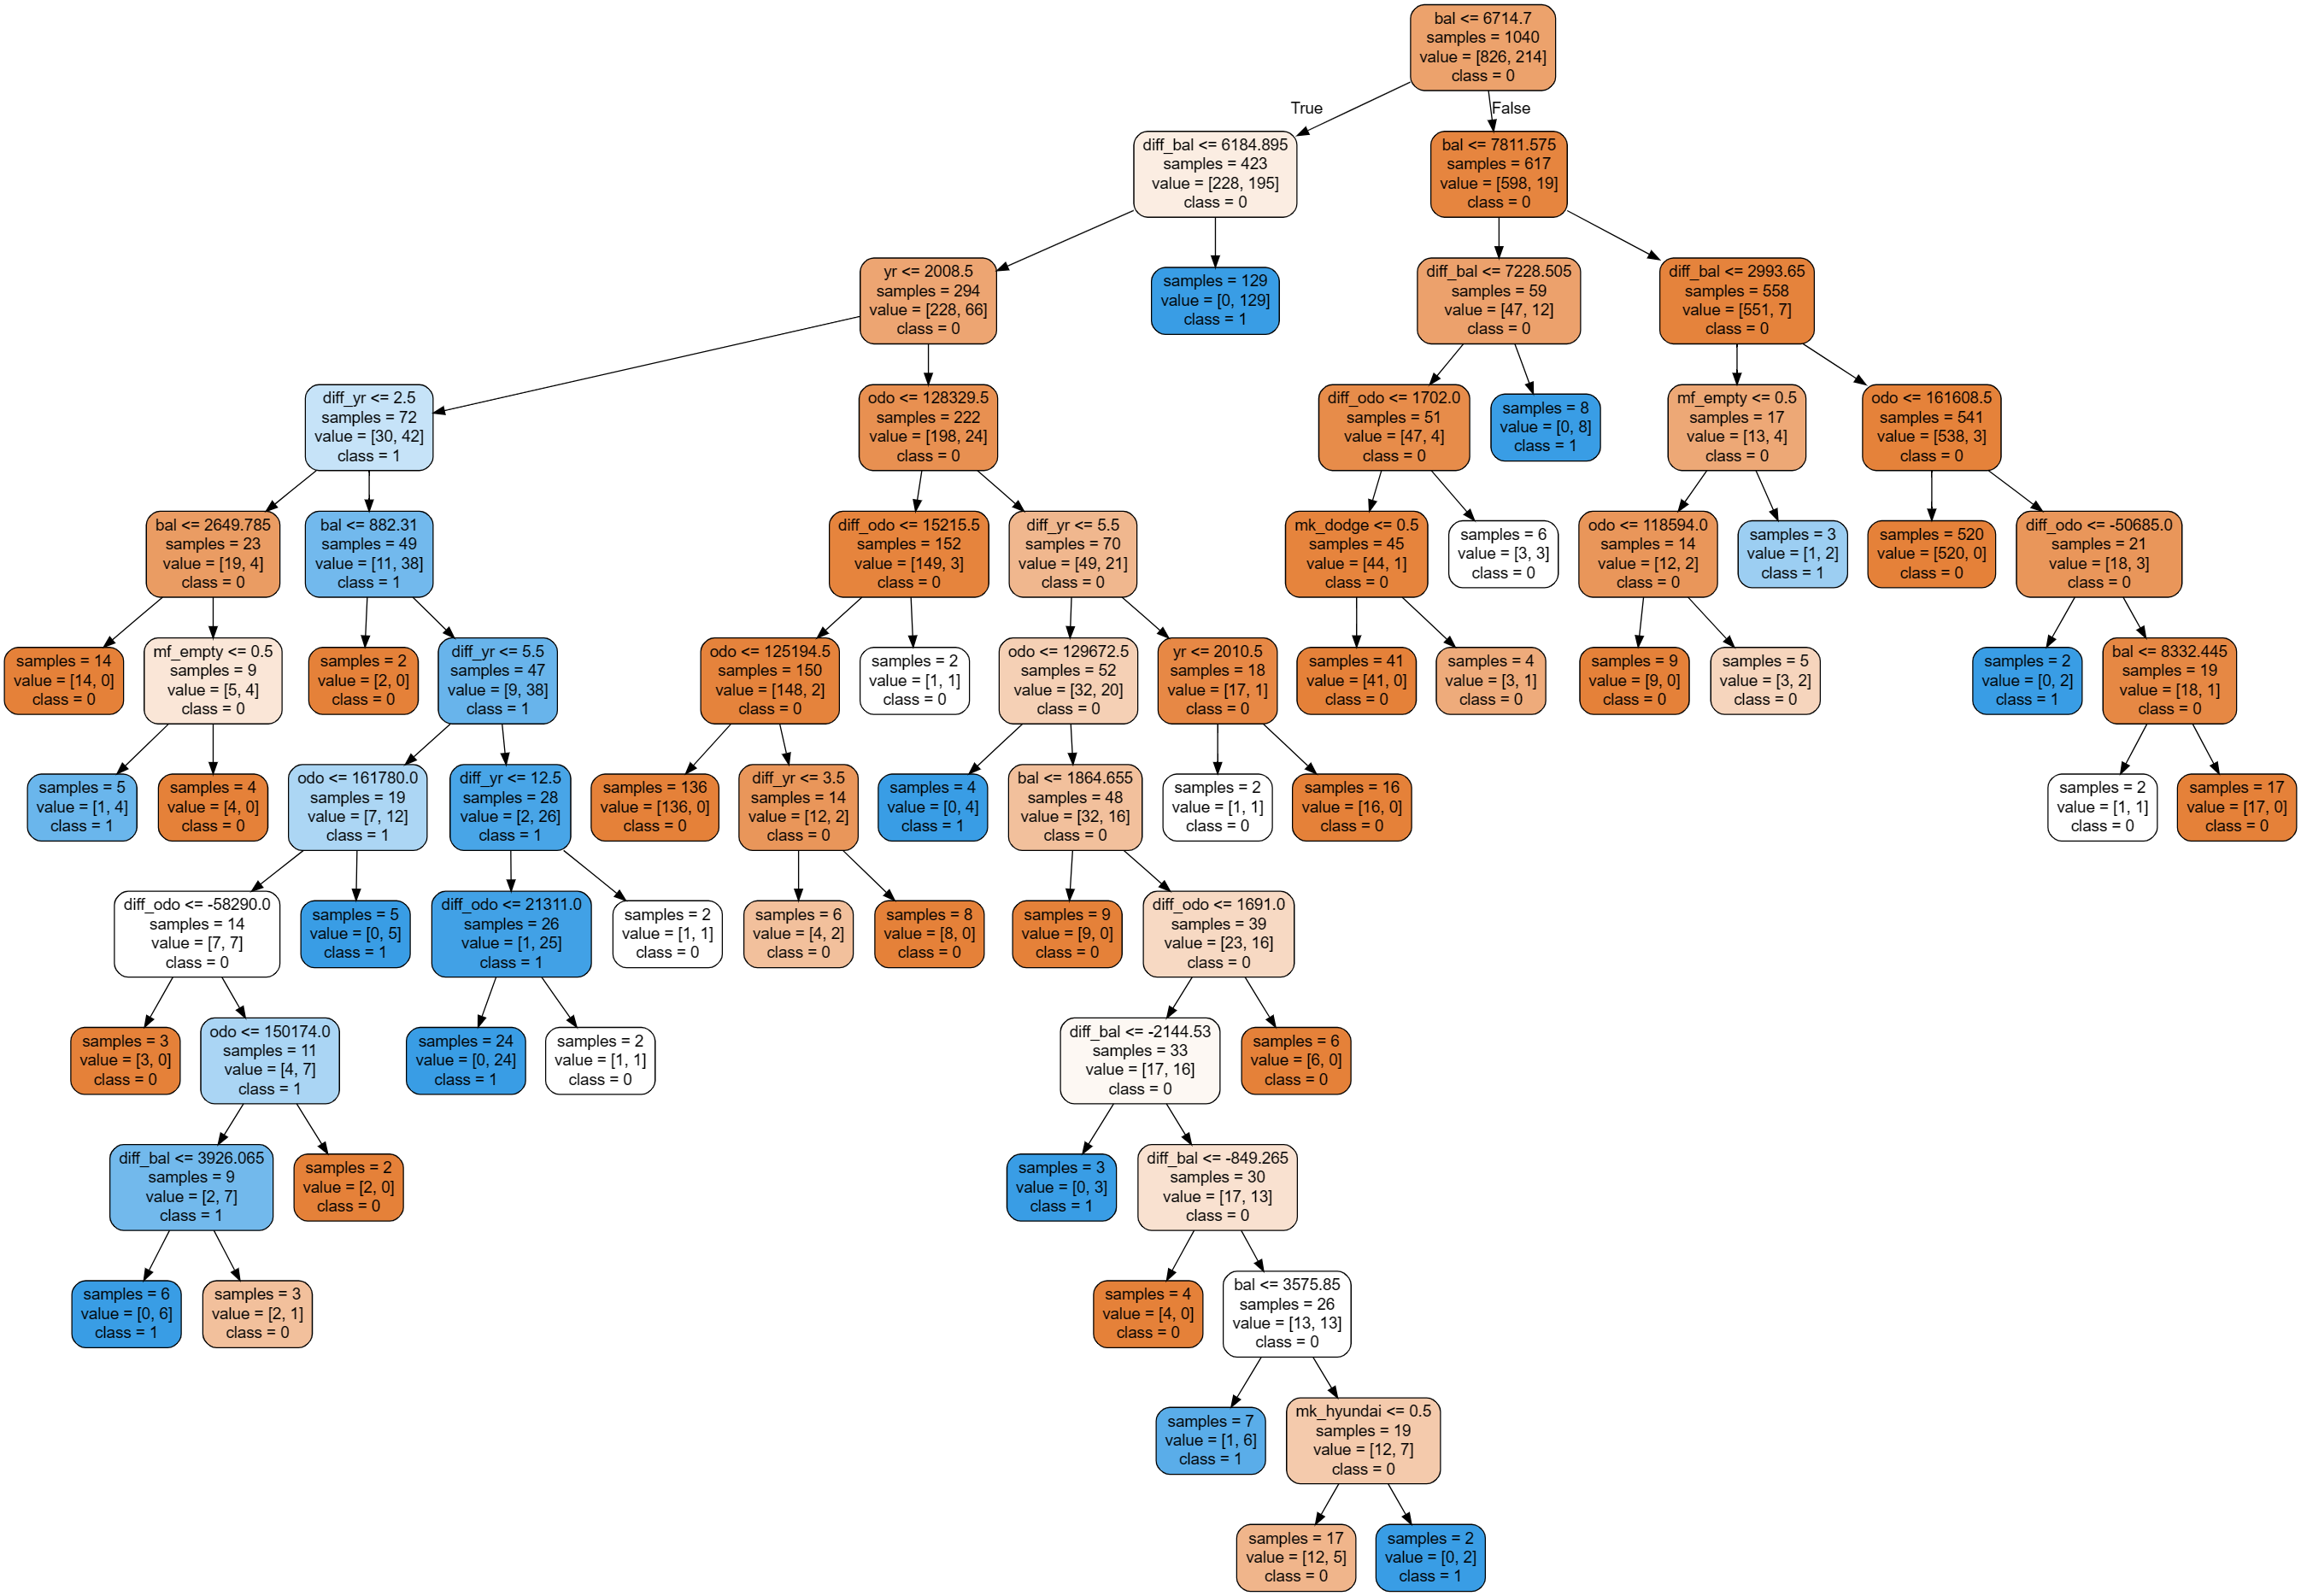

In [231]:
#can dig deeper into the photo from the file
Image(filename='graphviz.png')

In the end, the decision tree put emphasis on the above variables, so for the future analysis, we will simplify the dataset to only these. This will help with interpretability and communicating results to my boss, as long as it doesn't impact the performance of the models. By running it both ways, I noticed that using only these columns did not impact performance, implying the other variables are not very predictive.

# 7. Random Forest

In [232]:
rf_params = {
    'max_depth': list(range(10,20)),
    'min_samples_leaf': list(range(1,7)),
    'min_samples_split': list(range(10,20)),
    'n_estimators': [100],
}

In [233]:
rf = Train_Metrics(model_class = RandomForestClassifier, param_grid=rf_params, cv=10, scoring='f1', \
                                 X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, random_state = 42)

Best hyperparameters for GridSearchCV:  {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 100} Score: 0.67


 RandomForestClassifier Train accuracy: 0.941
-----------------
 RandomForestClassifier Train F1-score: 0.829
-----------------
 RandomForestClassifier Test accuracy: 0.854
-----------------
 RandomForestClassifier Test F1-score: 0.545 
-----------------


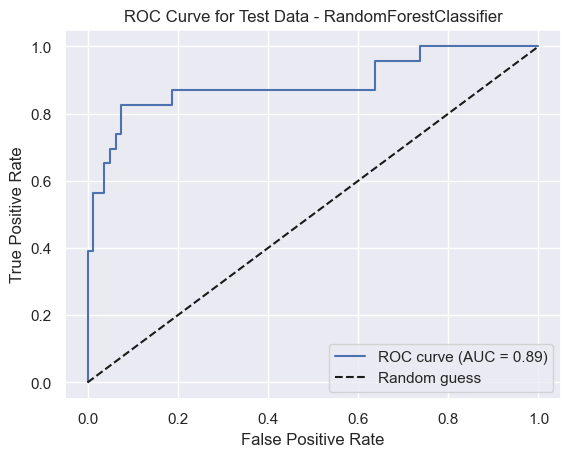

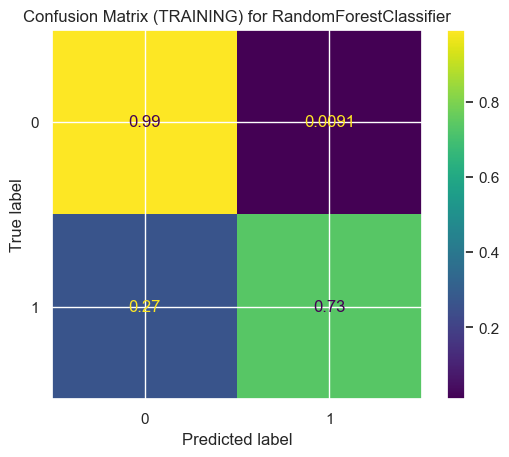

In [234]:
rf = rf.grid_search_train_metrics()

# 8. Gradient Boosted Classifier

In [235]:
#The performance is so good there is no use optimizing the other params
gb_params = {
    'n_estimators': [300],
    'learning_rate': [0.1, 0.01, 0.001]
#     ,'max_depth': list(range(5, 20)),
#     'min_samples_leaf': list(range(0, 15)),
#     'min_samples_split': list(range(10, 20)),
}

In [236]:
gb = Train_Metrics(model_class = GradientBoostingClassifier, param_grid=gb_params, cv=10, scoring='f1', \
                                 X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, random_state = 1)

Best hyperparameters for GridSearchCV:  {'learning_rate': 0.01, 'n_estimators': 300} Score: 0.75


 GradientBoostingClassifier Train accuracy: 0.956
-----------------
 GradientBoostingClassifier Train F1-score: 0.873
-----------------
 GradientBoostingClassifier Test accuracy: 0.883
-----------------
 GradientBoostingClassifier Test F1-score: 0.684 
-----------------


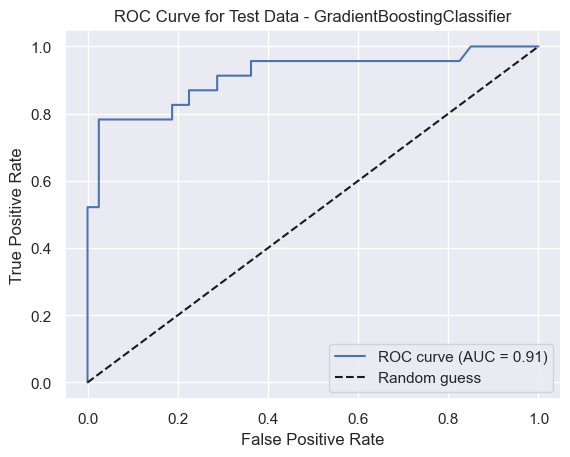

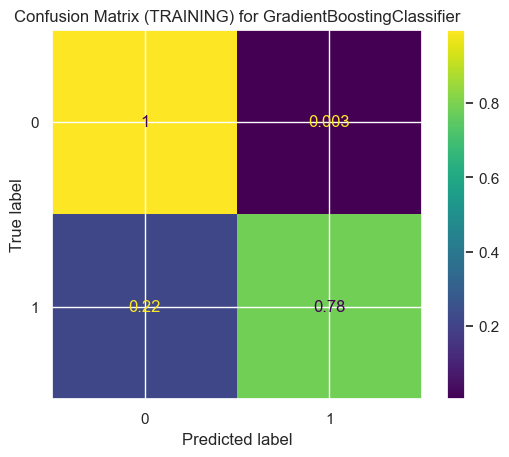

In [237]:
gb = gb.grid_search_train_metrics()

In [238]:
#May want to explore variable impact later

# 9. Logistic Regression 
This is binary classification, so log regression especially makes sense to try

In [239]:
#just to conform with Train_Metrics class
lr_params = {
    'penalty': ['l2'],
    'max_iter': [10000],
    'random_state': [42]
}

In [240]:
lr = Train_Metrics(model_class = LogisticRegression, param_grid=lr_params, cv=10, scoring='f1', \
                                 X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, random_state = 1)

Best hyperparameters for GridSearchCV:  {'max_iter': 10000, 'penalty': 'l2', 'random_state': 42} Score: 0.37


 LogisticRegression Train accuracy: 0.837
-----------------
 LogisticRegression Train F1-score: 0.396
-----------------
 LogisticRegression Test accuracy: 0.835
-----------------
 LogisticRegression Test F1-score: 0.485 
-----------------


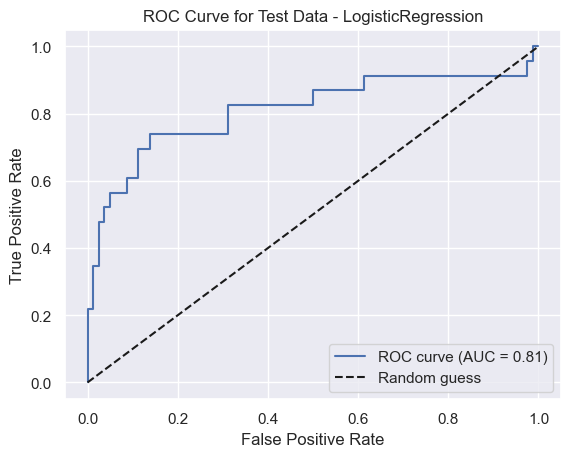

         Variable                    Weight
0              yr    -0.0038892832352810337
1             odo    4.7455312881265315e-05
2         diff_yr   -1.4724228462176156e-06
3        diff_odo    -7.833241503847386e-06
4        mk_acura     3.199621923075054e-07
5        mk_buick    1.8078246700113763e-07
6     mk_cadillac    1.3956881480638404e-08
7    mk_chevrolet     2.791120170721384e-07
8     mk_chrysler    -2.114708506977474e-08
9        mk_dodge    2.8114602430116302e-08
10        mk_ford    -6.903099719082804e-07
11         mk_gmc     4.065573639811545e-08
12       mk_honda     8.913225910042083e-08
13      mk_hummer   -5.4607927419820315e-08
14     mk_hyundai    -1.786043606261136e-07
15    mk_infiniti     -7.66608259672189e-08
16        mk_jeep   -3.2657011520539986e-07
17         mk_kia    -3.867656302342235e-07
18       mk_lexus    1.1413620943290656e-07
19     mk_lincoln      -7.4246416823644e-08
20       mk_mazda    -1.841440017002716e-08
21     mk_mercury     7.43644459

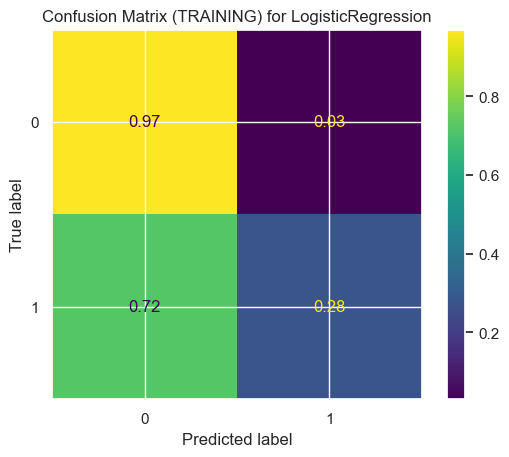

In [241]:
lr = lr.grid_search_train_metrics()

An idea for further analysis: we could try segmenting the balance into buckets (make it an object variable) to see which bucket is most predictive. Although, continuous data seems more precise for this task. Another idea would be to train on this data and then test on data from another year altogether, rather than doing train test split. Although, doing so may introduce conflating factors as predictive features could change between years.

# 10. Setting Up Prediction Data
In this section, I'm preprocessing the test data to be in the same format as the training data which I built the models on.

In [290]:
#instantiate
preprocessor = Preprocessing(df2)
#preprocess and set targets
preprocessor = preprocessor.process()
#reset trades (1) or don't (0)
keep_trades = int(input("Would you like to reset the trades? \n\n1=True: \n\n0=False\n\n"))
preprocessor = preprocessor.tr(keep_trades)
# #drop stock numbers
test_df = preprocessor

C:\Users\ADMIN\Preprocessing.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, features + cols_with_missing] = imputer.fit_transform(train_data.loc[:, features + cols_with_missing])


variables fixed

-----

0.8% of the values (12 values) were wholesale and cash deals (deleted).

-----

outliers truncated

--------



Would you like to reset the trades? 

1=True: 

0=False

1

-----

trade vars replaced and dropped


In [291]:
#instantiate
preprocessor = Preprocessing(df2)
#preprocess and set targets
preprocessor = preprocessor.process()
#reset trades (1) or don't (0)
keep_trades = int(input("Would you like to reset the trades? \n\n1=True: \n\n0=False\n\n"))
preprocessor = preprocessor.tr(keep_trades)
#drop stock numbers
test_df2 = preprocessor

C:\Users\ADMIN\Preprocessing.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, features + cols_with_missing] = imputer.fit_transform(train_data.loc[:, features + cols_with_missing])


variables fixed

-----

0.8% of the values (12 values) were wholesale and cash deals (deleted).

-----

outliers truncated

--------



Would you like to reset the trades? 

1=True: 

0=False

0

-----

trade vars not replaced, but dropped (along with t1)


In [292]:
#Drop Stock
stock_bal = test_df[['stock']]
stock2 = test_df2.stock
test_df.drop('stock', axis = 1, inplace = True)
test_df2.drop('stock', axis = 1, inplace = True)

            Target propensity per class  Total members in each class
pontiac                        1.000000                            5
suzuki                         1.000000                            3
subaru                         1.000000                            2
saturn                         0.750000                            4
lexus                          0.461538                           13
acura                          0.400000                           10
mazda                          0.333333                           12
hummer                         0.333333                            3
ram                            0.333333                            3
buick                          0.324324                           37
mitsubishi                     0.290323                           31
dodge                          0.284553                          123
chrysler                       0.258621                           58
toyota                         0.2

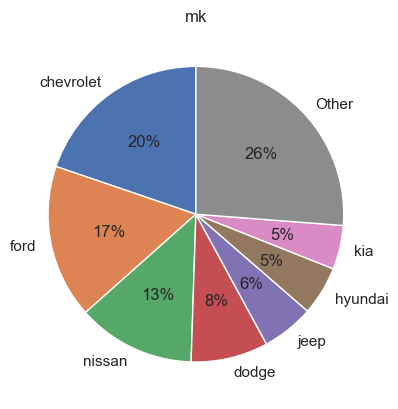

---------------------------------------------


       Target propensity per class  Total members in each class
empty                     0.258065                          434
F                         0.206208                          451
M                         0.190227                          573


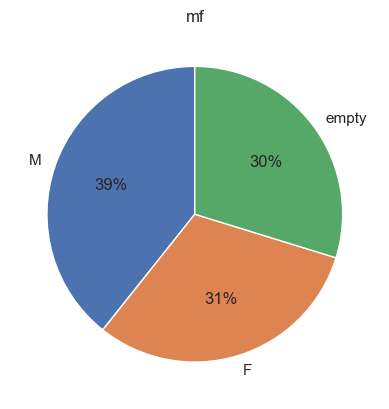

---------------------------------------------




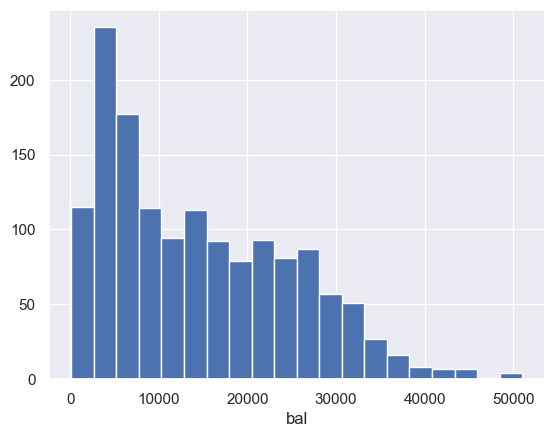

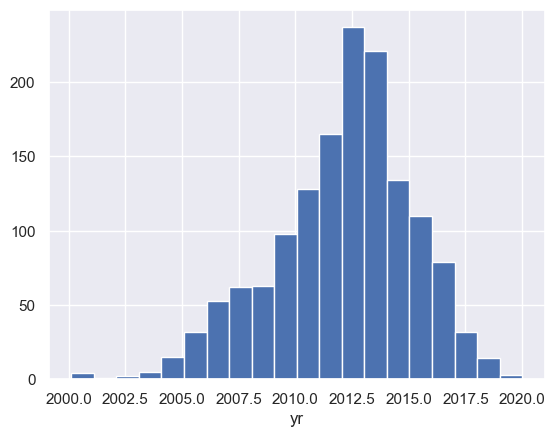

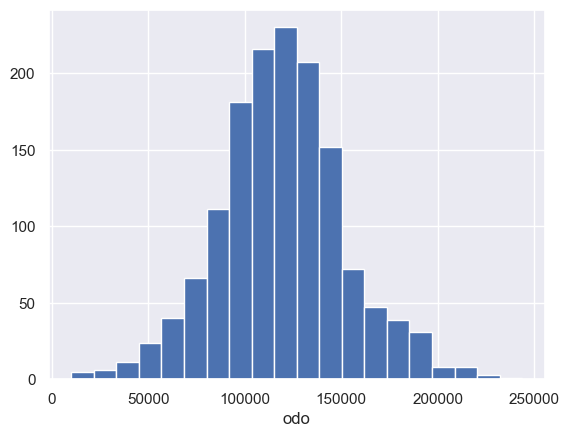

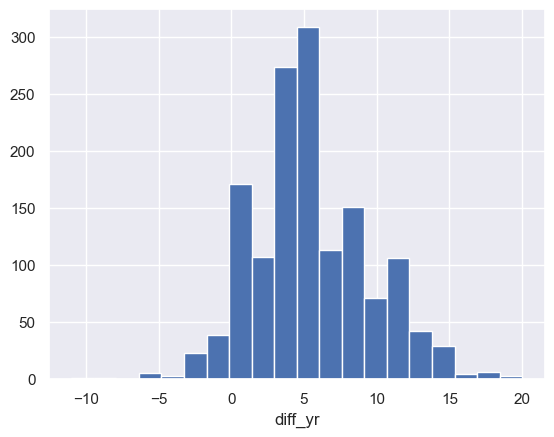

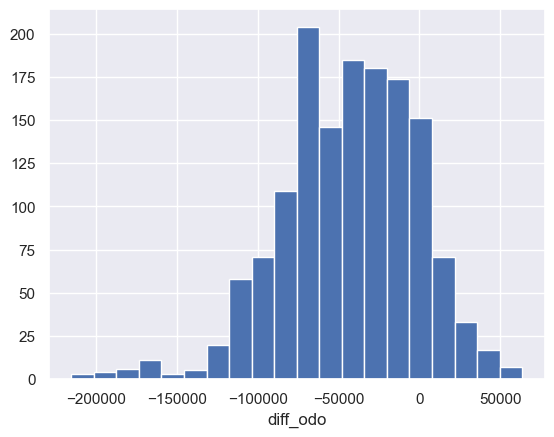

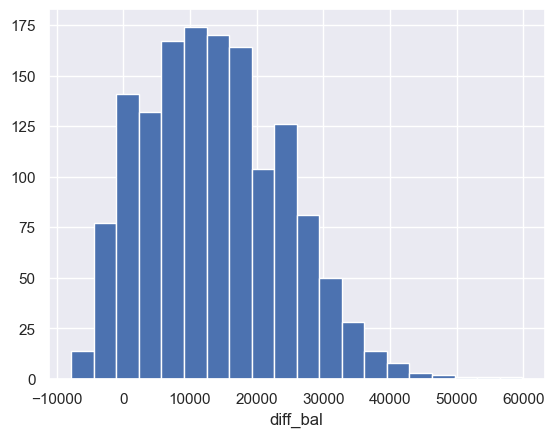

In [293]:
Visualization(test_df).all_viz()

In [294]:
test_df = Encode_Normalize_Multicol(test_df, 0.8).encode_normalize_multicol()

encoded


In [295]:
test_df2 = Encode_Normalize_Multicol(test_df2, 0.8).encode_normalize_multicol()

encoded


In [296]:
test_t1 = test_df.t1

train_cols = X_train.columns
test_cols = test_df.columns

# Difference in both directions
train_not_test = train_cols.difference(test_cols)
test_not_train = test_cols.difference(train_cols)
train_not_test = [col for col in train_not_test]
test_not_train = [col for col in test_not_train]

# Add columns to test_df which appear in X_train
for col in train_not_test:
    test_df[col] = 0

# Remove columns in test_df which do not appear in X_train
for col in test_not_train:
    test_df.drop(col, axis = 1, inplace = True)
    
# Reorder the columns in test_df to match those in X_train
test_df = test_df[X_train.columns]

In [297]:
# test_t1 = test_df.t1
train_cols = X_train.columns
test_cols = test_df2.columns

# Difference in both directions
train_not_test = train_cols.difference(test_cols)
test_not_train = test_cols.difference(train_cols)
train_not_test = [col for col in train_not_test]
test_not_train = [col for col in test_not_train]

# Add columns to test_df which appear in X_train
for col in train_not_test:
    test_df2[col] = 0

# Remove columns in test_df which do not appear in X_train
for col in test_not_train:
    test_df2.drop(col, axis = 1, inplace = True)
    
# Reorder the columns in test_df to match those in X_train
test_df2 = test_df2[X_train.columns]

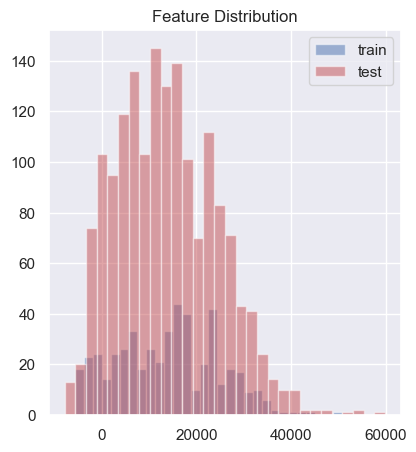

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)

var_n = train_df.dtypes.index
var = 'diff_bal'
plt.hist(train_df[var], bins=30, alpha=0.5, label='train', color='b')
plt.hist(test_df[var], bins=30, alpha=0.5, label='test', color='r')
plt.title('Feature Distribution')
plt.legend()


In [271]:
abc = model.predict(test_df2)
sum(abc)/len(abc)
abc[-1000:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [97]:
y_preddt = model.predict(test_df2)

In [92]:
df2['Balance Remaining'] = pd.to_numeric(df2['Balance Remaining'], errors='coerce')
df2[df2['Balance Remaining'] < 6714.17]

,StockNbr,Balance Remaining,Total Repairs,Nbr Pmts Remaining,Interest Rate,Trade Year,Trade Make,Trade Odometer,Trade Amount,Trade Lien,...,Odometer,Date of Birth,Primary Gender,Days Late,Debt to Income Ratio,Joint Monthly Income,Primary Monthly Income,Nbr of Dependents,Net Income,PrimaryScoreModelA
42,190978,540.22,"4,142.91",2,21.9,2002.0,Nissan,EXEMPT,"1,500.00",0.00,...,131891,64043901CD495BBFEA06B4AC28528C6B,M,-8,0.0,0,0,NaN,0,0
57,190602,351.41,734.69,1,19.9,2004.0,Mercury,EXEMPT,500.00,0.00,...,44595,866F00E72F0718CE5E7BDC45C3AF5F06,NaN,-8,0.0,2100,2000,NaN,0,0
80,190688,585.37,"1,801.94",2,24.9,NaN,NaN,NaN,0.00,0.00,...,129911,72697FB6352198EDBD7636E33A490BF7,M,20,0.0,0,2400,NaN,0,0
105,191156,955.09,335.00,4,21.9,2009.0,GMC,134612,"3,000.00",0.00,...,83953,BDAD7EE8E3B5407C36D201FC26108F15,NaN,-2,0.0,0,0,NaN,0,0
106,191180,788.16,725.13,3,24.9,NaN,NaN,NaN,0.00,0.00,...,100304,E8FA2B6F5B16D72523D9594489472F66,F,-2,0.0,0,0,NaN,0,0
123,191039,791.77,"1,013.94",4,14.9,NaN,NaN,NaN,0.00,0.00,...,51952,C121DDD2DDDC07AEF6B65D66C3396260,M,-11,0.0,0,0,NaN,0,0
201,191095,277.82,"2,767.40",0,24.9,NaN,NaN,NaN,0.00,0.00,...,109168,5CB4C2DCC9F331136AF46DB18EB66870,M,10,0.0,6600,3120,0.0,0,0
210,191193,463.30,"2,229.95",2,24.9,NaN,NaN,NaN,0.00,0.00,...,153147,67B8E08A292404120B09B62515074419,NaN,-1,18.5,3500,2000,0.0,1630,32
580,180368,947.88,"2,797.38",5,18.9,2007.0,Ford,EXEMPT,"3,500.00","4,877.60",...,89082,0506111BD385CCF30DE723281E6C3DDF,NaN,-8,0.0,0,0,NaN,0,0
928,200125,639.42,"1,015.23",4,21.9,NaN,NaN,NaN,0.00,0.00,...,170599,EFB327AFE21A182BB42F09793B1A5CB1,NaN,-1,25.7,1680,1920,0.0,1427,56


In [149]:
test_df2 = pd.concat([stock_bal.stock, test_df2], axis=1)


In [151]:
df2

,StockNbr,Balance Remaining,Total Repairs,Nbr Pmts Remaining,Interest Rate,Trade Year,Trade Make,Trade Odometer,Trade Amount,Trade Lien,...,Odometer,Date of Birth,Primary Gender,Days Late,Debt to Income Ratio,Joint Monthly Income,Primary Monthly Income,Nbr of Dependents,Net Income,PrimaryScoreModelA
0,202599,NaN,73.70,107,17.9,2012.0,Ford,193793,"1,000.00",827.49,...,53561,3445F5E39ABDBAAAA40A6E23A3A8F3DE,M,-1,11.0,0,7000,0.0,6230,46
1,202583,NaN,703.70,75,18.9,NaN,NaN,NaN,0.00,0.00,...,71440,23C4C1043B1C4ABEF6D8BF87A847790F,M,-2,18.8,0,2400,0.0,1950,24
2,202662,NaN,600.00,96,14.9,2013.0,Nissan,124193,"2,000.00","4,473.14",...,122949,793A731596112EB43A90D8CC5D3FF1A7,M,-9,17.8,2200,2000,0.0,1643,31
3,202530,NaN,"1,483.42",98,14.9,NaN,NaN,NaN,0.00,0.00,...,94990,AC7F490E4B22713AEBDCEA4B95F2CF86,NaN,0,21.8,0,3300,1.0,2581,46
4,202559,NaN,925.80,99,15.9,2010.0,Chevrolet,145340,"5,000.00","6,343.39",...,122091,3AE9DAADA5EB131B4BEE320842D2DA69,NaN,-2,29.9,1920,2800,0.0,3311,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,101537,500.0,0.00,1,0.0,NaN,NaN,NaN,0.00,0.00,...,unknwon,NaN,NaN,234,0.0,0,0,NaN,0,0
861,101546,NaN,0.00,1,0.0,NaN,NaN,NaN,0.00,0.00,...,unknwon,NaN,NaN,218,0.0,0,0,NaN,0,0
863,101549,500.0,0.00,1,0.0,NaN,NaN,NaN,0.00,0.00,...,unknwon,NaN,NaN,215,0.0,0,0,NaN,0,0
890,203604,NaN,"1,508.51",313,17.9,NaN,NaN,NaN,0.00,0.00,...,124785,74090132D6CC6D084975ED878F76CA59,M,-1,51.0,0,2500,0.0,1225,53


In [150]:
test_df2

,stock,bal,yr,odo,diff_yr,diff_odo,diff_bal,mk_acura,mk_buick,mk_cadillac,...,mk_saturn,mk_scion,mk_subaru,mk_suzuki,mk_toyota,mk_volkswagen,mk_volvo,mf_F,mf_M,mf_empty
0,202599,26832.44,2019.0,53561.0,7.0,-140232.0,26004.95,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,202583,28388.02,2016.0,71440.0,5.0,-68142.0,23791.97,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,202662,29060.25,2014.0,122949.0,1.0,-1244.0,24587.11,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,202530,28067.93,2012.0,94990.0,-4.0,-52456.0,20842.58,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,202559,29827.81,2015.0,122091.0,5.0,-23249.0,23484.42,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,203699,29547.46,2013.0,106073.0,3.0,-39293.0,23162.49,0,0,0,...,0,0,0,0,0,0,0,0,0,1
797,203680,27442.68,2014.0,111563.0,8.0,-62711.0,26562.25,0,0,0,...,0,0,0,0,0,0,0,1,0,0
798,203896,12559.78,2006.0,158573.0,-2.0,8573.0,8037.60,0,0,0,...,0,0,0,0,1,0,0,0,1,0
843,203186,11081.47,2006.0,150463.0,-2.0,463.0,6559.29,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [152]:
test_df2[test_df2.bal < 6714]

,stock,bal,yr,odo,diff_yr,diff_odo,diff_bal,mk_acura,mk_buick,mk_cadillac,...,mk_saturn,mk_scion,mk_subaru,mk_suzuki,mk_toyota,mk_volkswagen,mk_volvo,mf_F,mf_M,mf_empty
317,203234,6034.38,2014.0,145853.0,6.0,-4147.0,1512.20,0,0,0,...,0,0,0,0,0,0,0,0,1,0
589,Consumer,1456.87,2011.0,113398.0,3.0,-24361.0,-2170.16,0,0,0,...,0,0,0,0,0,0,0,0,1,0
741,203784,2102.81,2007.0,101112.0,-1.0,-44254.0,-1524.22,0,0,1,...,0,0,0,0,0,0,0,0,1,0
749,203866,2237.16,2012.0,146031.0,4.0,-3969.0,-2285.02,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 11. Making Predictions On New Data And Downloading Reports
Which customers are likely to trade and take on a new loan?

In [117]:
#Make Predictions on df
y_preddt = dt.predict(test_df)
y_predrf = rf.predict(test_df)
y_predgb = gb.predict(test_df)
y_predlr = lr.predict(test_df)

In [119]:
#Make Predictions on df2
y_preddt2 = dt.predict(test_df2)
y_predrf2 = rf.predict(test_df2)
y_predgb2 = gb.predict(test_df2)
y_predlr2 = lr.predict(test_df2)

In [51]:
comps1 = pd.DataFrame([test_t1, y_preddt, y_predrf, y_predgb, y_predlr]).T.reset_index(drop=True)
comps1.columns = ['true target', 'dt', 'rf', 'gb', 'lr']
comps2 = pd.DataFrame([test_t1, y_preddt2, y_predrf2, y_predgb2, y_predlr2]).T.reset_index(drop=True)
comps2.columns = ['true target', 'dt', 'rf', 'gb', 'lr']

In [52]:
print(f'This is what happens when we predict on cars where the tr vars are subbed for current vars: \n\n{comps1.head(15)}\n\nAccuracy:\
\n{accuracy_score(test_t1, y_preddt)}\n{accuracy_score(test_t1, y_predrf)}\n\
{accuracy_score(test_t1, y_predgb)}\n{accuracy_score(test_t1, y_predlr)}')

This is what happens when we predict on cars where the tr vars are subbed for current vars: 

    true target   dt   rf   gb   lr
0           1.0  1.0  1.0  1.0  1.0
1           0.0  0.0  0.0  0.0  0.0
2           1.0  1.0  1.0  1.0  1.0
3           0.0  0.0  0.0  0.0  0.0
4           1.0  1.0  1.0  1.0  1.0
5           1.0  1.0  1.0  1.0  1.0
6           0.0  0.0  0.0  0.0  0.0
7           0.0  0.0  0.0  0.0  0.0
8           0.0  1.0  1.0  1.0  1.0
9           1.0  0.0  0.0  0.0  0.0
10          0.0  0.0  0.0  0.0  0.0
11          0.0  0.0  0.0  0.0  0.0
12          0.0  1.0  1.0  1.0  1.0
13          1.0  0.0  0.0  0.0  0.0
14          0.0  1.0  1.0  1.0  1.0

Accuracy:
0.972183588317107
0.9749652294853964
0.9791376912378303
0.9958275382475661


In [53]:
pct_t1 = round(100*len(test_t1[test_t1==1])/len(test_t1), 2)
print(f'This is what happens when we predict on transactions with only their current vehicle values: \n\n{comps2.head(15)}\n\nAccuracy:\
\n{accuracy_score(test_t1, y_preddt2)}\n{accuracy_score(test_t1, y_predrf2)}\n\
{accuracy_score(test_t1, y_predgb2)}\n{accuracy_score(test_t1, y_predlr2)}')
print(f'\n-------------------\n\nAs you can see, it predicts everything as 0, and the original data has only {pct_t1}% targets')

This is what happens when we predict on transactions with only their current vehicle values: 

    true target   dt   rf   gb   lr
0           1.0  0.0  0.0  0.0  0.0
1           0.0  0.0  0.0  0.0  0.0
2           1.0  0.0  0.0  0.0  0.0
3           0.0  0.0  0.0  0.0  0.0
4           1.0  0.0  0.0  0.0  0.0
5           1.0  0.0  0.0  0.0  0.0
6           0.0  0.0  0.0  0.0  0.0
7           0.0  0.0  0.0  0.0  0.0
8           0.0  0.0  0.0  0.0  0.0
9           1.0  0.0  0.0  0.0  0.0
10          0.0  0.0  0.0  0.0  0.0
11          0.0  0.0  0.0  0.0  0.0
12          0.0  0.0  0.0  0.0  0.0
13          1.0  0.0  0.0  0.0  0.0
14          0.0  0.0  0.0  0.0  0.0

Accuracy:
0.799721835883171
0.7983310152990264
0.7983310152990264
0.7983310152990264

-------------------

As you can see, it predicts everything as 0, and the original data has only 20.17% targets


In [ ]:
instance_index = 0  # index of the instance you're interested in
instance = test_df2[instance_index].reshape(1, -1)  # reshape is necessary to make it 2D
path = clf.decision_path(instance)

In [46]:
print(accuracy_score(test_t1, y_preddt),'\n',
accuracy_score(test_t1, y_predrf),'\n',
accuracy_score(test_t1, y_predgb),'\n',
accuracy_score(test_t1, y_predlr))

0.980528511821975 
 0.9694019471488178 
 0.9819193324061196 
 0.9958275382475661


In [47]:
common = test_df.merge(X_train, indicator=True, how='inner')
print("As you can see, the predictions were made on unseen data\nNumber of rows in test_df that are also in X_train:", common.shape[0])

As you can see, the predictions were made on unseen data
Number of rows in test_df that are also in X_train: 0


In [48]:
#Setup table
finaldt = pd.DataFrame([stock_bal['stock'], y_preddt])
finaldt = finaldt.T
finaldt.columns = ['stock','prediction']

finalrf = pd.DataFrame([stock_bal['stock'], y_predrf])
finalrf = finalrf.T
finalrf.columns = ['stock','prediction']

finalgb = pd.DataFrame([stock_bal['stock'], y_predgb])
finalgb = finalgb.T
finalgb.columns = ['stock','prediction']

finallr = pd.DataFrame([stock_bal['stock'], y_predlr])
finallr = finallr.T
finallr.columns = ['stock','prediction']

In [49]:
#Isolate positives
positivedt = finaldt[finaldt['prediction'] == 1]
positivedt = positivedt.rename(columns={'prediction': 'dt'})

positiverf = finalrf[finalrf['prediction'] == 1]
positiverf = positiverf.rename(columns={'prediction': 'rf'})

positivegb = finalgb[finalgb['prediction'] == 1]
positivegb = positivegb.rename(columns={'prediction': 'gb'})

positivelr = finallr[finallr['prediction'] == 1]
positivelr = positivelr.rename(columns={'prediction': 'lr'})

In [50]:
#Combine tables
partial1 = pd.merge(positivegb, positivelr, on='stock', how = 'outer')
partial2 = pd.merge(positiverf, partial1, on='stock', how = 'outer')
scores = pd.merge(positivedt, partial2, how = 'outer', on='stock')
scores.columns = ['stock', 'Decision Tree', 'Random Forest', 'GBoost','Logistic Regression']

scores.fillna(0, inplace = True)

scores['Score'] = scores['Decision Tree'] + scores['Random Forest'] + scores['GBoost'] + scores['Logistic Regression']
scores = scores.sort_values(by = 'Score', ascending = False)

In [51]:
#merge with original data
scores = pd.merge(stock_bal, scores, on='stock', how = 'inner')

In [52]:
scores

,stock,bal,Decision Tree,Random Forest,GBoost,Logistic Regression,Score
0,202599,827.49,1.0,1.0,1.0,1.0,4.0
1,202662,4473.14,1.0,1.0,1.0,1.0,4.0
2,202559,6343.39,1.0,1.0,1.0,1.0,4.0
3,202561,7051.71,1.0,1.0,1.0,1.0,4.0
4,202666,26008.81,1.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...
124,203686,21230.62,1.0,1.0,1.0,1.0,4.0
125,203727,3459.74,0.0,0.0,0.0,1.0,1.0
126,203765,38846.47,1.0,1.0,1.0,1.0,4.0
127,203712,25711.66,1.0,1.0,1.0,1.0,4.0


In [53]:
filtered_report = scores[(scores.Score == 4) & (scores.bal < 7000)]

In [54]:
filtered_report

,stock,bal,Decision Tree,Random Forest,GBoost,Logistic Regression,Score
0,202599,827.49,1.0,1.0,1.0,1.0,4.0
1,202662,4473.14,1.0,1.0,1.0,1.0,4.0
2,202559,6343.39,1.0,1.0,1.0,1.0,4.0
7,202205,4784.72,1.0,1.0,1.0,1.0,4.0
17,202889,4054.36,1.0,1.0,1.0,1.0,4.0
23,202725,5166.57,1.0,1.0,1.0,1.0,4.0
41,202788,2566.90,1.0,1.0,1.0,1.0,4.0
50,202744,6146.90,1.0,1.0,1.0,1.0,4.0
53,203195,5694.86,1.0,1.0,1.0,1.0,4.0
59,203172,6670.76,1.0,1.0,1.0,1.0,4.0


#18. Export data for management

In [55]:
scores.to_csv('Report for Allen.csv', index=False)

In [56]:
filtered_report.to_csv('Best.csv', index=False)